In [303]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import math


sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('Cognizant share prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df2 = pd.read_csv('HCL Technologies share prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df3 = pd.read_csv('HDFC Bank Share Prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df4 = pd.read_csv('ICICI Bank Share Prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df5 = pd.read_csv('Infosys Share Prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df6 = pd.read_csv('SBI Share Prices 2019_2021.csv',parse_dates=['Date'],index_col='Date')
df7 = pd.read_csv('USD-INR Exchange rate 2019_2021.csv',parse_dates=['Date'],index_col='Date')

In [3]:
df1

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,62.500000,63.810001,62.500000,63.090000,3045600
2019-01-03,62.360001,62.970001,61.009998,61.099998,3895700
2019-01-04,62.279999,63.799999,61.950001,63.700001,4885600
2019-01-07,63.349998,63.970001,62.799999,63.599998,3940400
2019-01-08,64.269997,64.430000,63.439999,64.320000,3427500
...,...,...,...,...,...
2021-09-27,77.349998,78.290001,76.809998,78.029999,2884400
2021-09-28,77.709999,77.830002,76.180000,76.360001,2959500
2021-09-29,76.260002,76.559998,75.489998,75.580002,2062100


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 694 entries, 2019-01-02 to 2021-10-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    694 non-null    float64
 1   High    694 non-null    float64
 2   Low     694 non-null    float64
 3   Close   694 non-null    float64
 4   Volume  694 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 32.5 KB


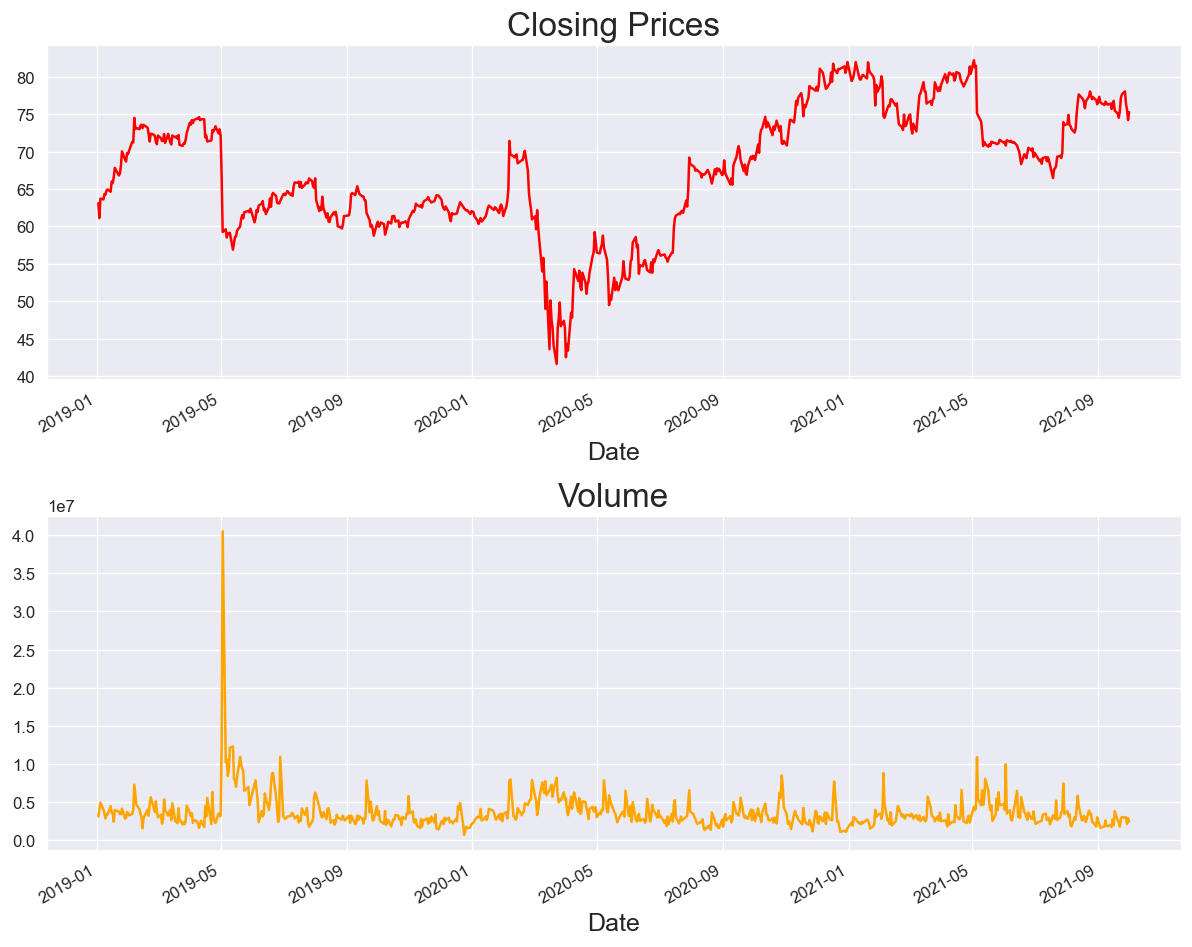

In [227]:
_, axes = plt.subplots(2,1,figsize=(10,8))



df1['Close'].plot(ax=axes[0],color='red')
axes[0].set_title('Closing Prices',size=20)
axes[0].set_xlabel('Date',size=15)


df1['Volume'].plot(ax=axes[1],color='orange')
axes[1].set_title('Volume',size=20)
axes[1].set_xlabel('Date',size=15)


plt.tight_layout()
plt.show()

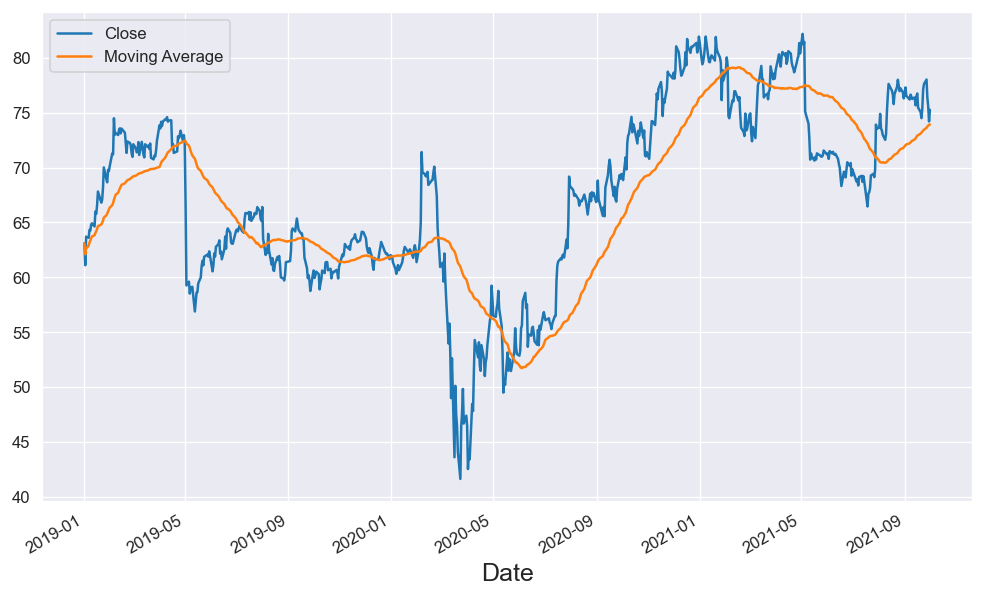

In [228]:
#Looking more closely at the Close Prices
#Simple Moving average
rolling_df1 = df1.Close.rolling('90D').mean()

plt.figure(figsize=(10,6))

df1['Close'].plot()
rolling_df1.plot()

plt.xlabel('Date',size=15)
plt.legend(['Close','Moving Average'])

plt.show()

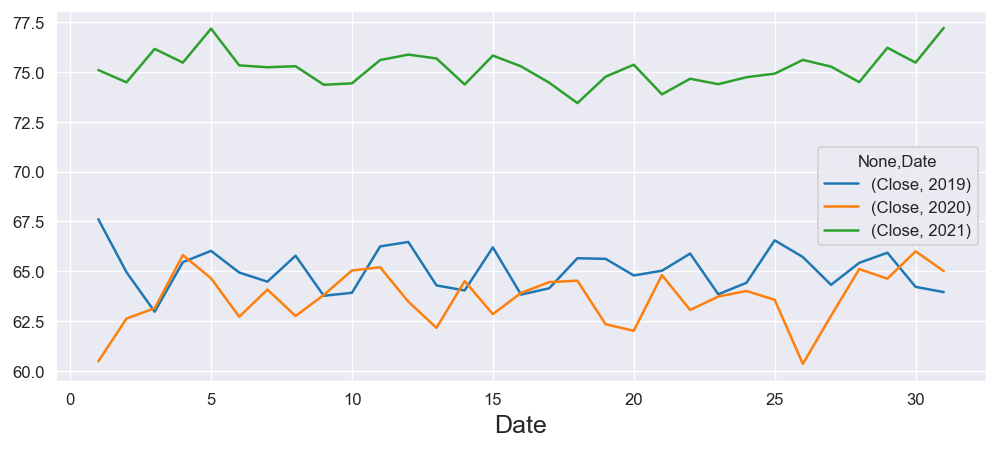

In [229]:
#Seasonality

def seasonal_plot(df, season='year', index='month', column=None):
    if column == None:
        column = df.columns[0]
    
    piv_index = getattr(df.index,index)
    piv_season = getattr(df.index,season)

    piv = pd.pivot_table(df,index=piv_index, columns= piv_season, values=[column], aggfunc='mean')
    piv.plot(figsize=(10,4))
    plt.xlabel('Date',size=15)

seasonal_plot(df1,season='year',index='day',column='Close')


In [77]:
result = seasonal_decompose(df1.Close, model='additive', period=90)

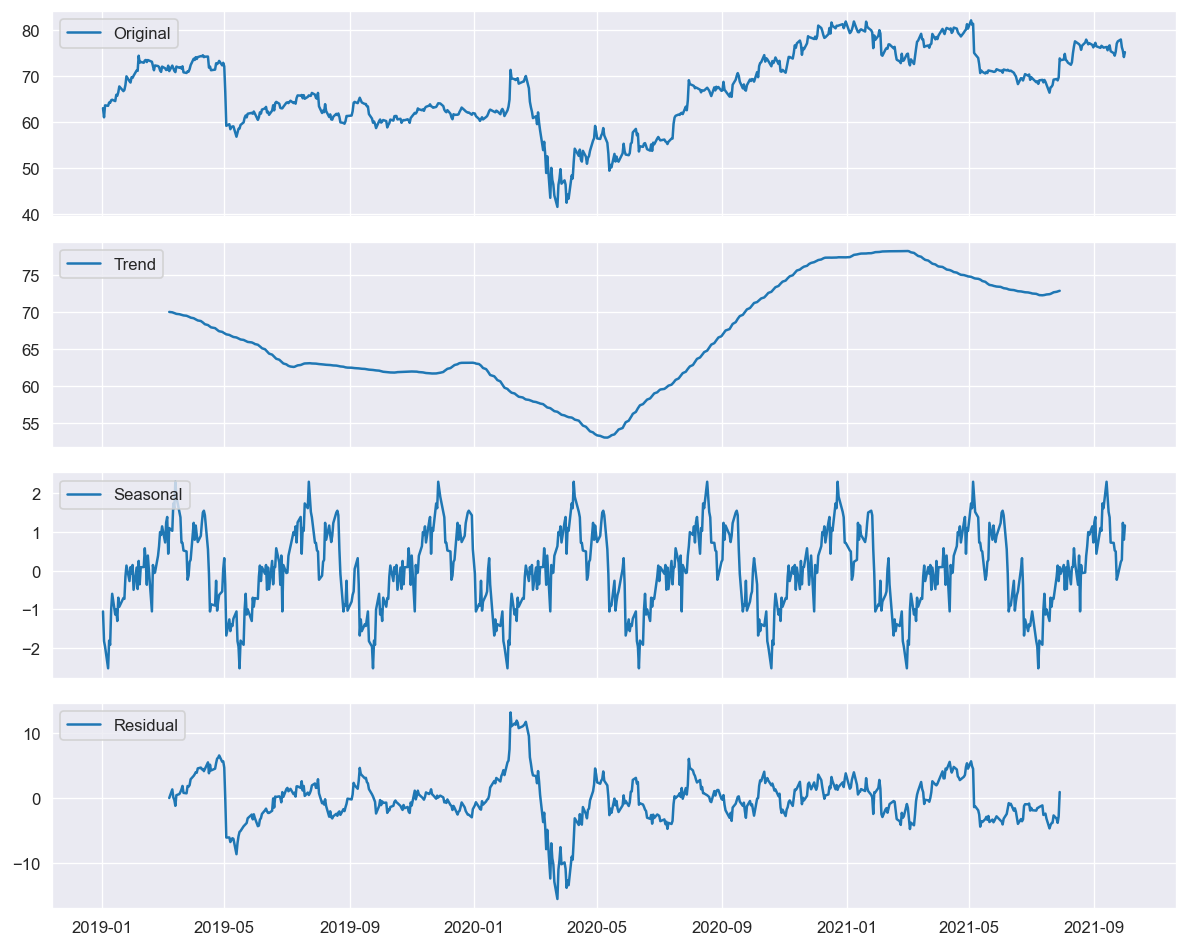

In [78]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(df1.index, df1['Close'], label='Original')
ax1.legend(loc='upper left')

ax2.plot(df1.index, result.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(df1.index, result.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(df1.index, result.resid, label='Residual')
ax4.legend(loc='upper left')

plt.tight_layout()
plt.show()

We can observe the lack of conrete seasonal patterns

#### Building an ARIMA model

In [8]:
#ADF Test for determining d

result = adfuller(df1.Close)
print('ADF Statistic: %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic: -2.078685
p-value: 0.253171


Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

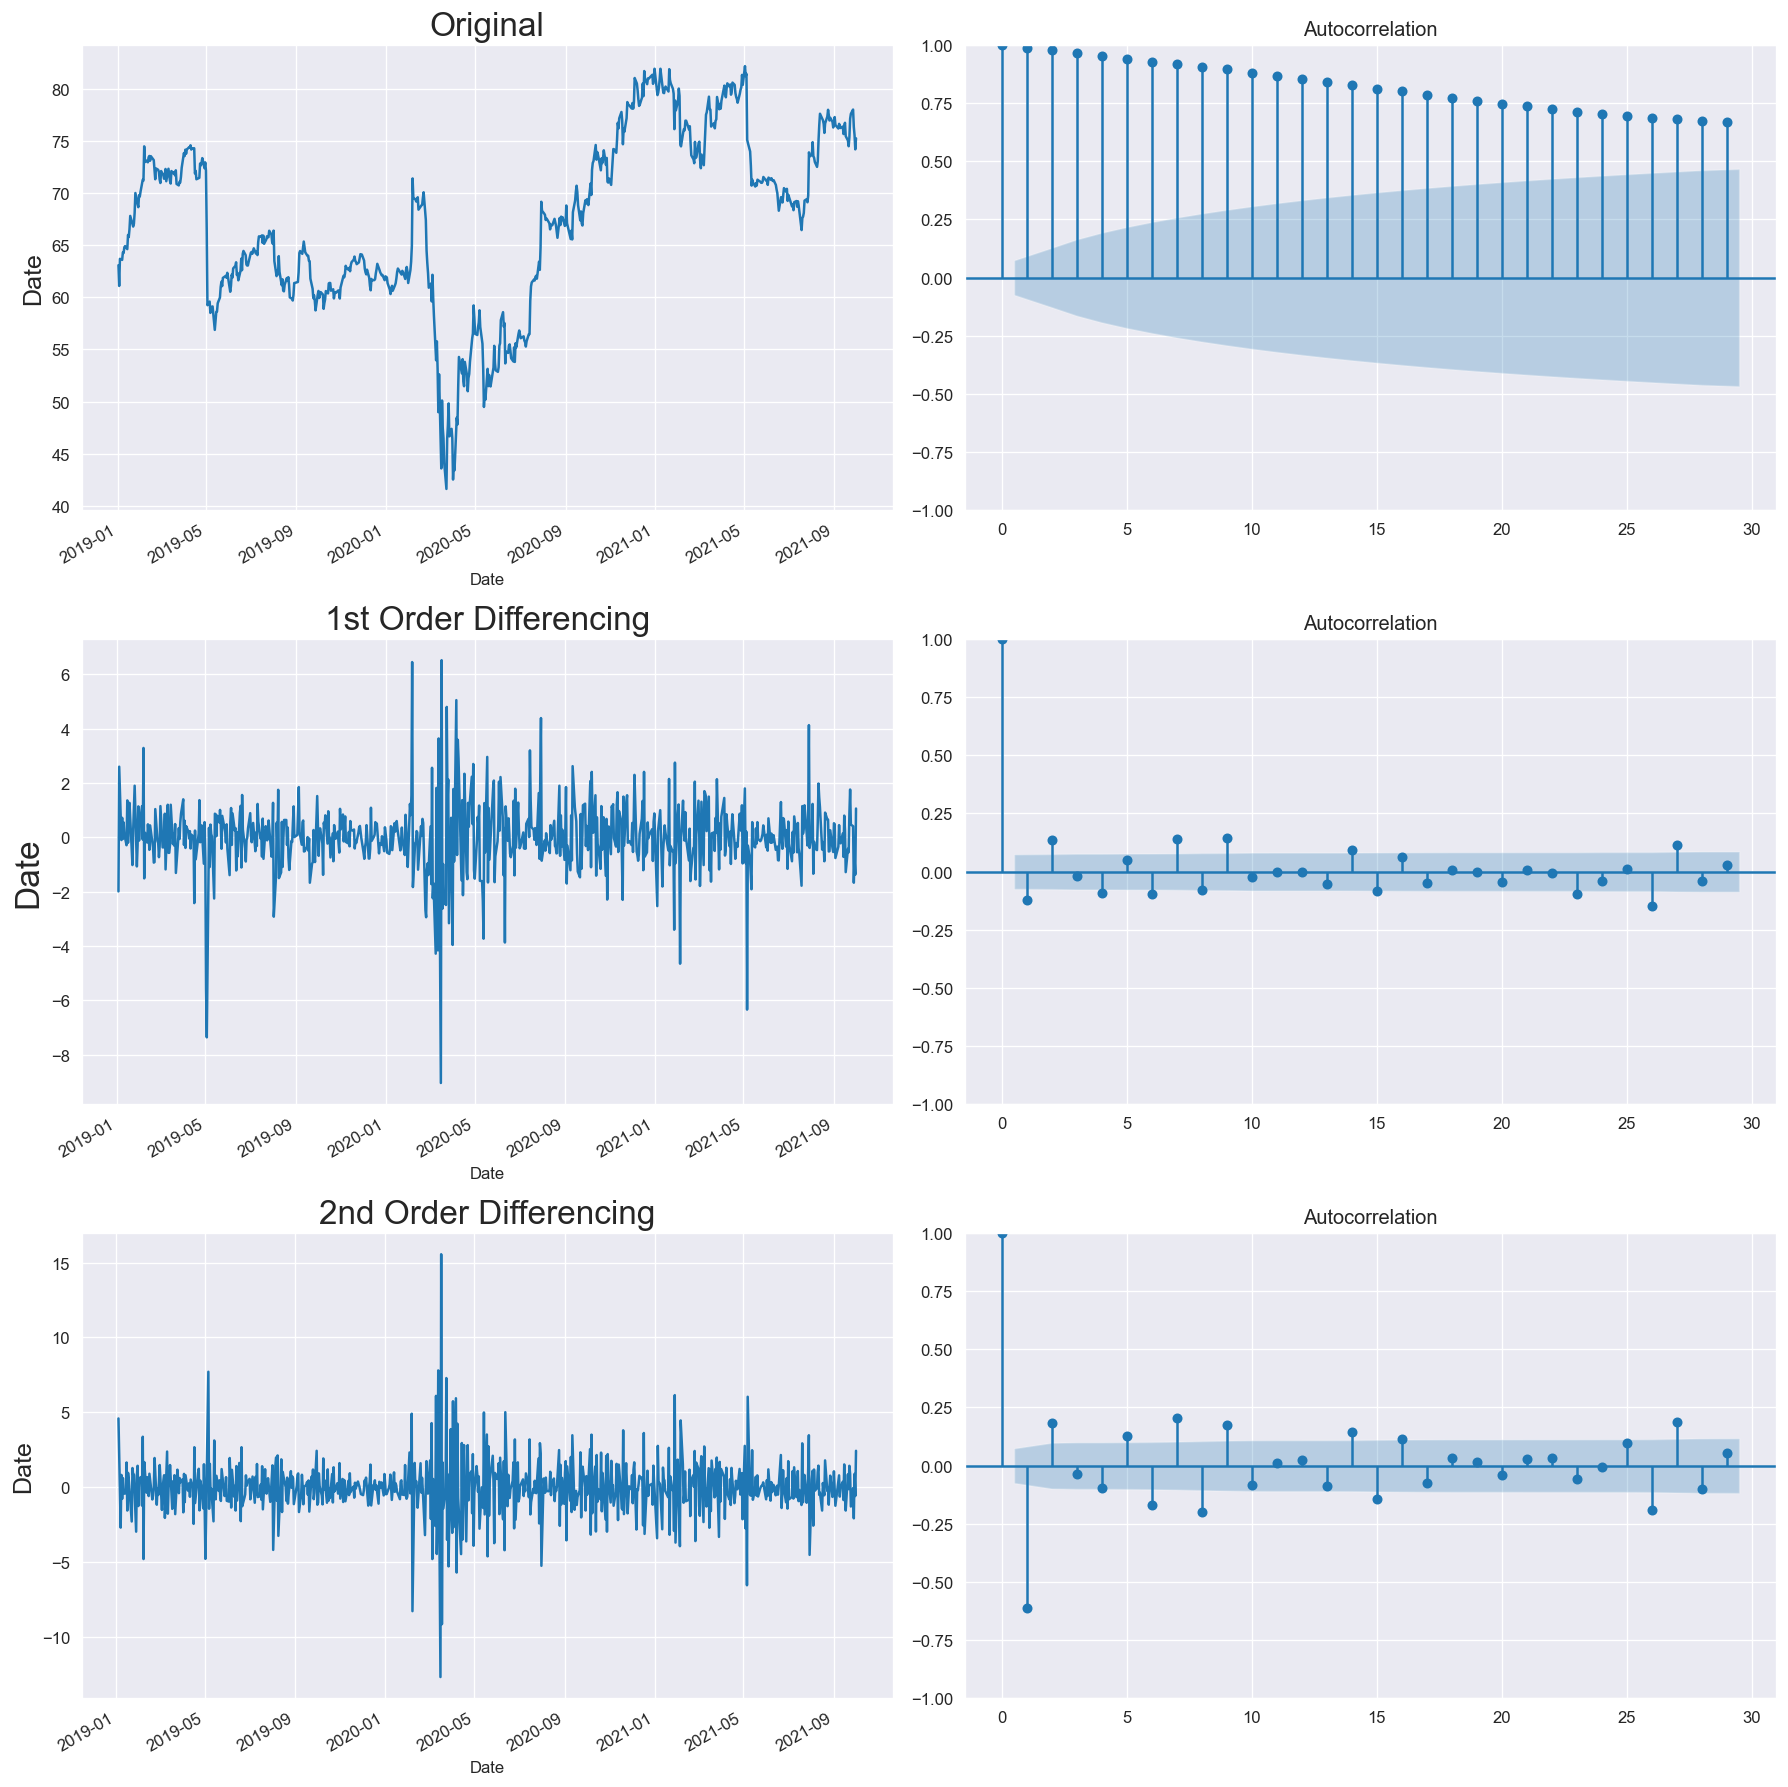

In [241]:
# Original Series
fig, axes = plt.subplots(3, 2,figsize=(15,15))
df1.Close.plot(ax=axes[0,0])
plot_acf(df1.Close,ax=axes[0,1])
axes[0,0].set_title('Original',size=20)
axes[0,0].set_ylabel('Date',size=15)

# 1st Differencing
df1.Close.diff().plot(ax=axes[1,0])
plot_acf(df1.Close.diff().dropna(),ax=axes[1,1])
axes[1,0].set_title('1st Order Differencing',size=20)
axes[1,0].set_ylabel('Date',size=20)

# 2nd Differencing
df1.Close.diff().diff().plot(ax=axes[2,0])
plot_acf(df1.Close.diff().diff().dropna(),ax=axes[2,1])
axes[2,0].set_title('2nd Order Differencing',size=20)
axes[2,0].set_ylabel('Date',size=15)

plt.tight_layout()

plt.show()

For the above data, we can see that the time series reaches stationarity with one order of differencing.

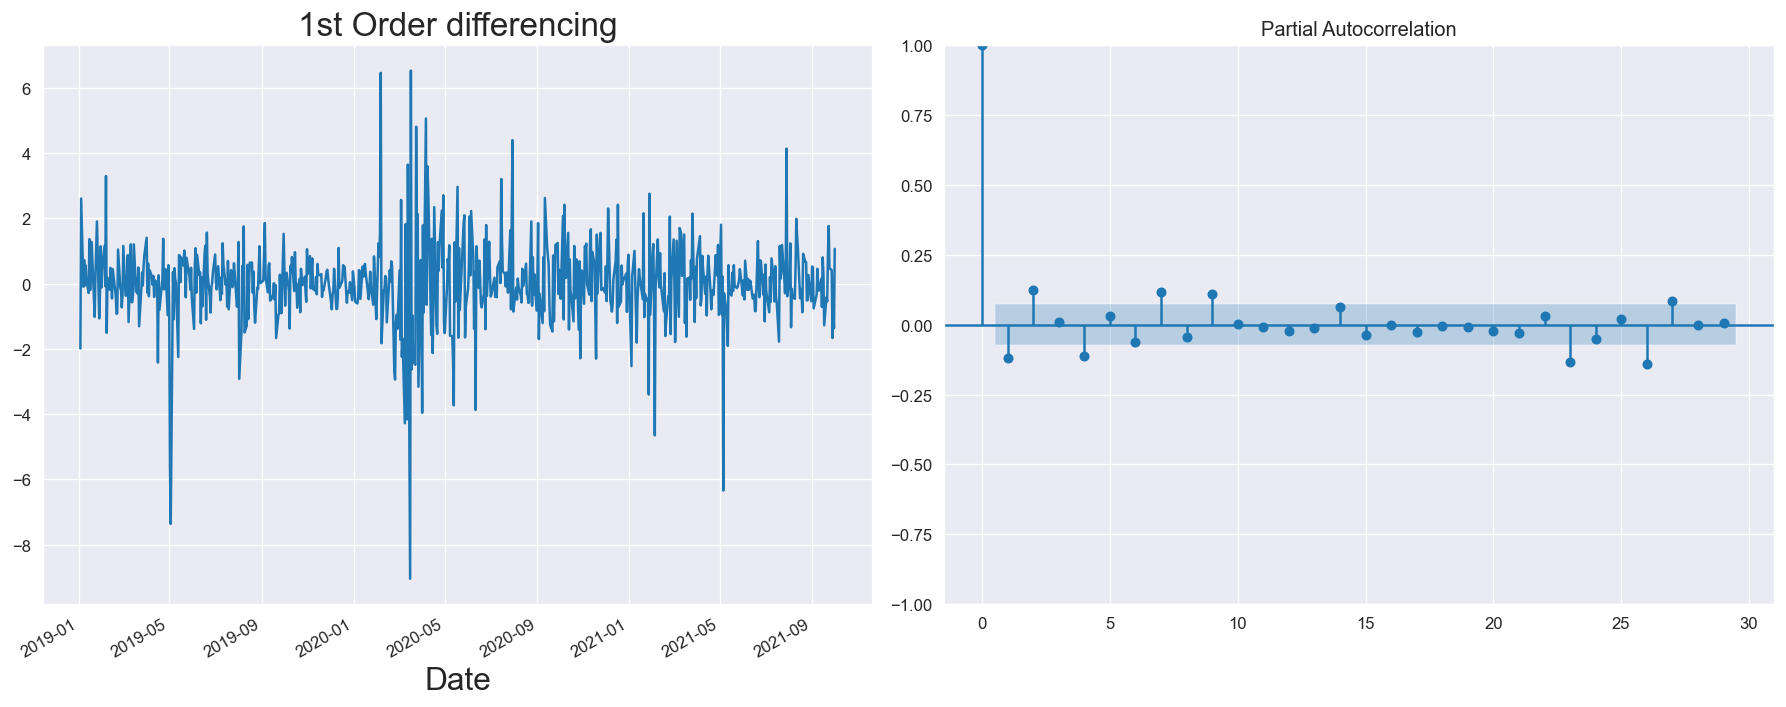

In [255]:
#Using the PACF to determine the value of p

fig, axes = plt.subplots(1,2,figsize=(15,6))

df1.Close.diff().plot(ax=axes[0])
axes[0].set_title('1st Order differencing',size=20)
axes[0].set_xlabel('Date',size=19)
plot_pacf(df1.Close.diff().dropna(),ax=axes[1])

plt.tight_layout()
plt.show()


A significant drop in the PACF occurs after the second lag. We can select the order of p as 1

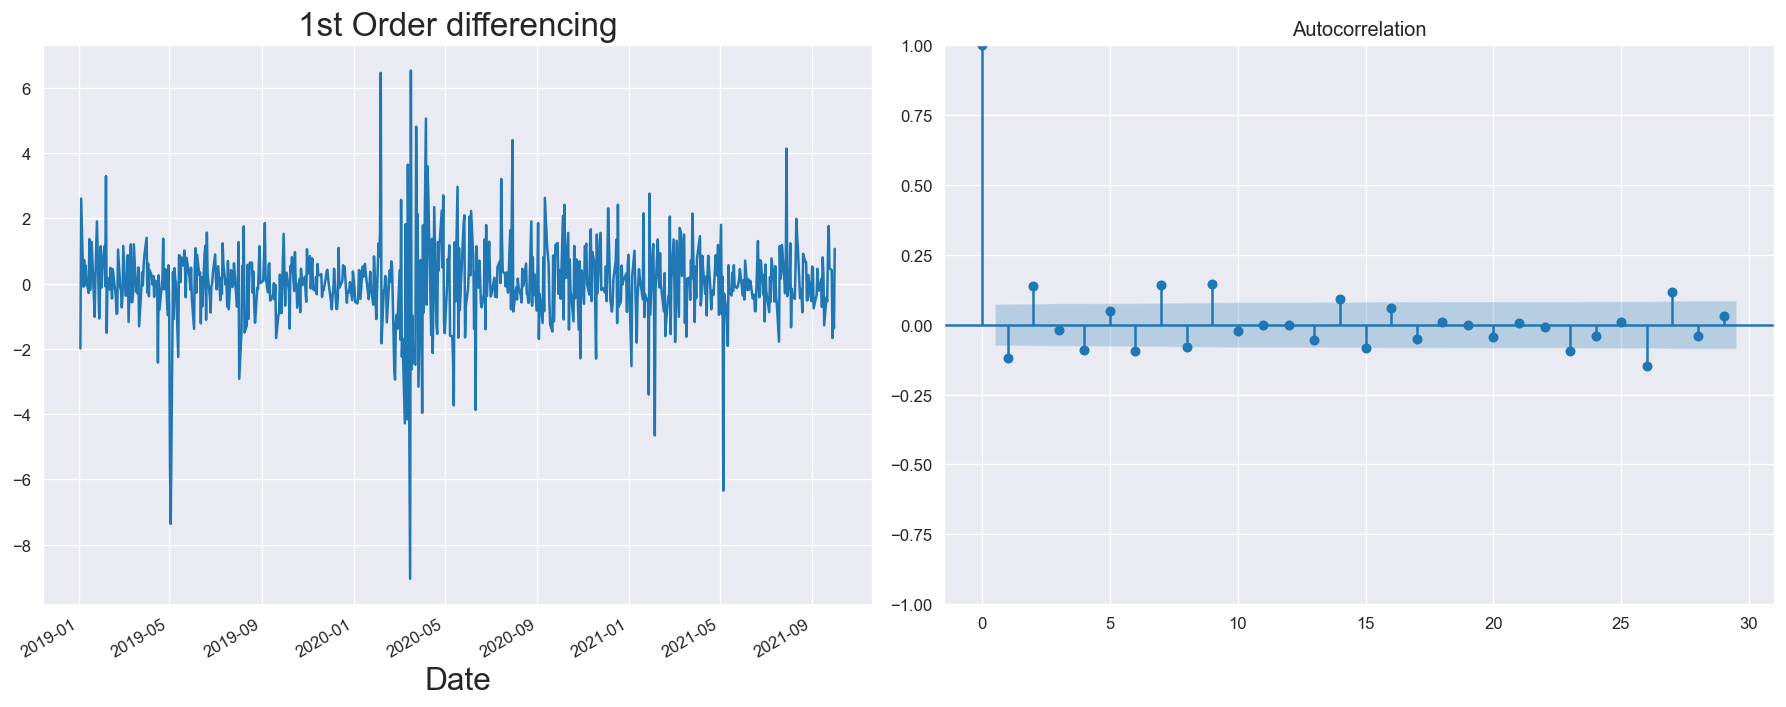

In [256]:
#Using the ACF to determine the value of q

fig, axes = plt.subplots(1,2,figsize=(15,6))


df1.Close.diff().plot(ax=axes[0])
axes[0].set_title('1st Order differencing',size=20)
axes[0].set_xlabel('Date',size=19)
plot_acf(df1.Close.diff().dropna(),ax=axes[1])

plt.tight_layout()
plt.show()

There is one lag is that is sufficiently above the significance level. Therefore, q is also taken as 1

In [12]:
#Building the ARIMA model

#2,2,2 model
model = ARIMA(df1.Close,order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  694
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1154.275
Date:                Sat, 25 Nov 2023   AIC                           2314.551
Time:                        14:25:50   BIC                           2328.174
Sample:                             0   HQIC                          2319.819
                                - 694                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4826      0.148     -3.256      0.001      -0.773      -0.192
ma.L1          0.3521      0.155      2.275      0.023       0.049       0.656
sigma2         1.6377      0.039     41.721      0.0

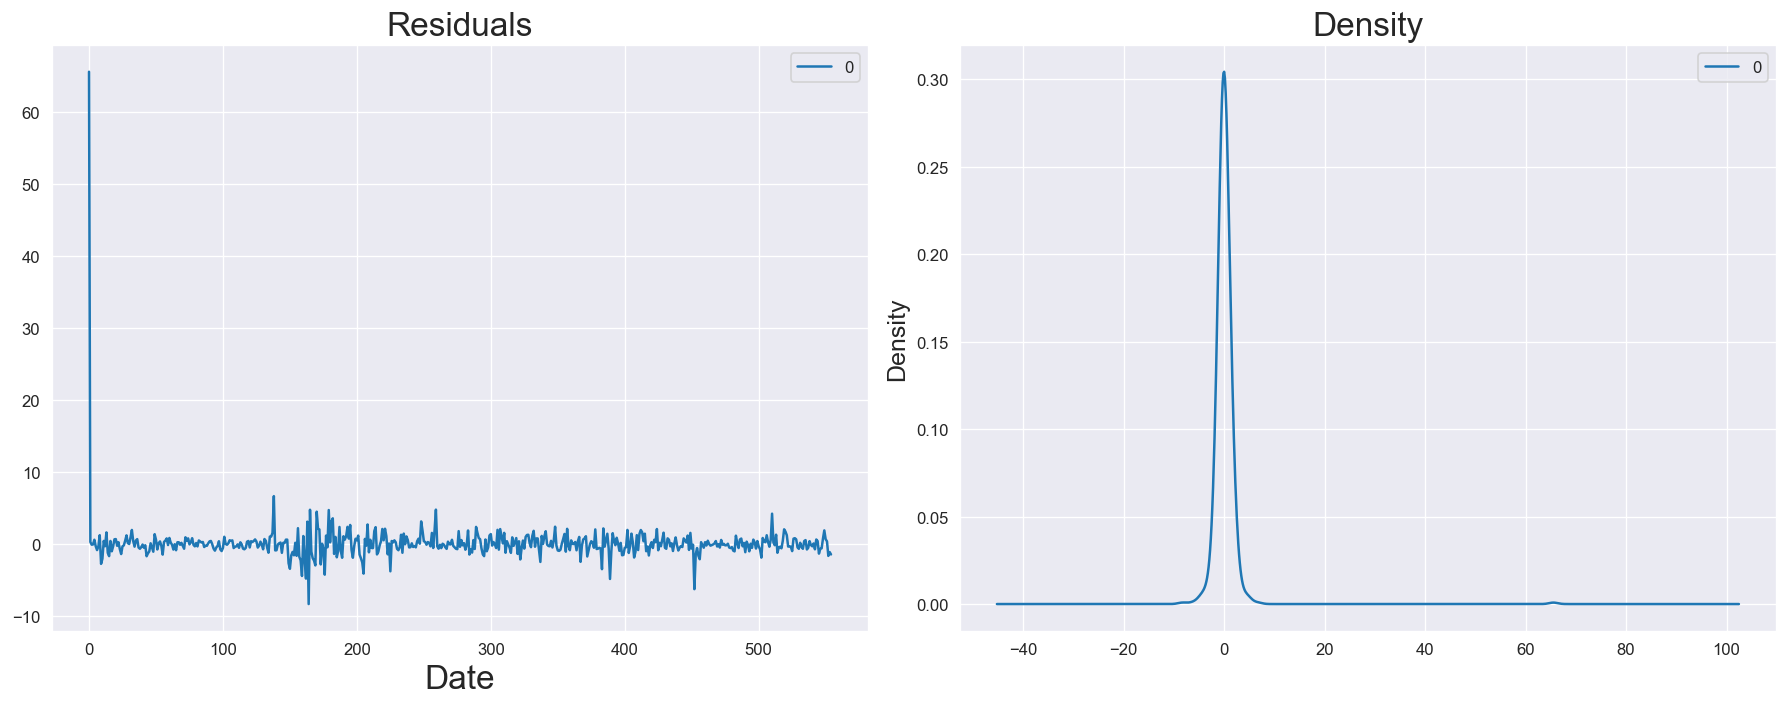

In [253]:
residuals = pd.DataFrame(model_fit.resid)
_, axes = plt.subplots(1,2,figsize=(15,6))

residuals.plot(ax=axes[0])
axes[0].set_title('Residuals',size=20)
axes[0].set_xlabel('Date',size=20)

residuals.plot(kind='kde',ax=axes[1])
axes[1].set_title('Density',size=20)
axes[1].set_ylabel('Density',size=15)

plt.tight_layout()

plt.show()

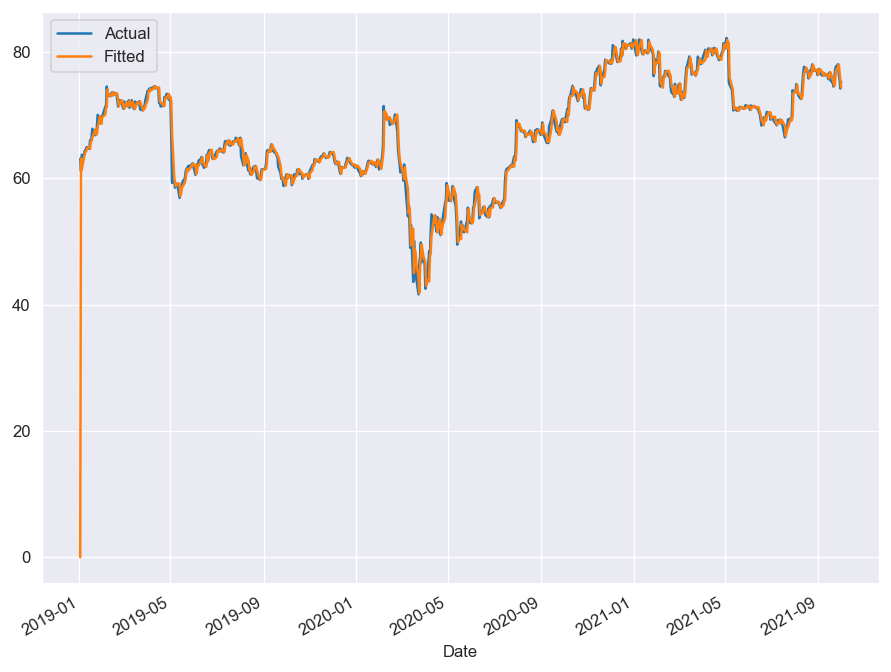

In [14]:
#Actual vs Fitted

df1.Close.plot()
model_fit.predict().plot()

plt.legend(['Actual','Fitted'])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

In [82]:
train_size = int(0.8*len(df1))
test_size = len(df1)-train_size

train = df1.Close[:train_size]
test = df1.Close[train_size:]

In [83]:
predictions = []

history = [x for x in train]

for i in range(len(test)):
    model = ARIMA(history,order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[i])
    history.pop(0)


In [84]:
forecasts = pd.Series(predictions, index = test.index)

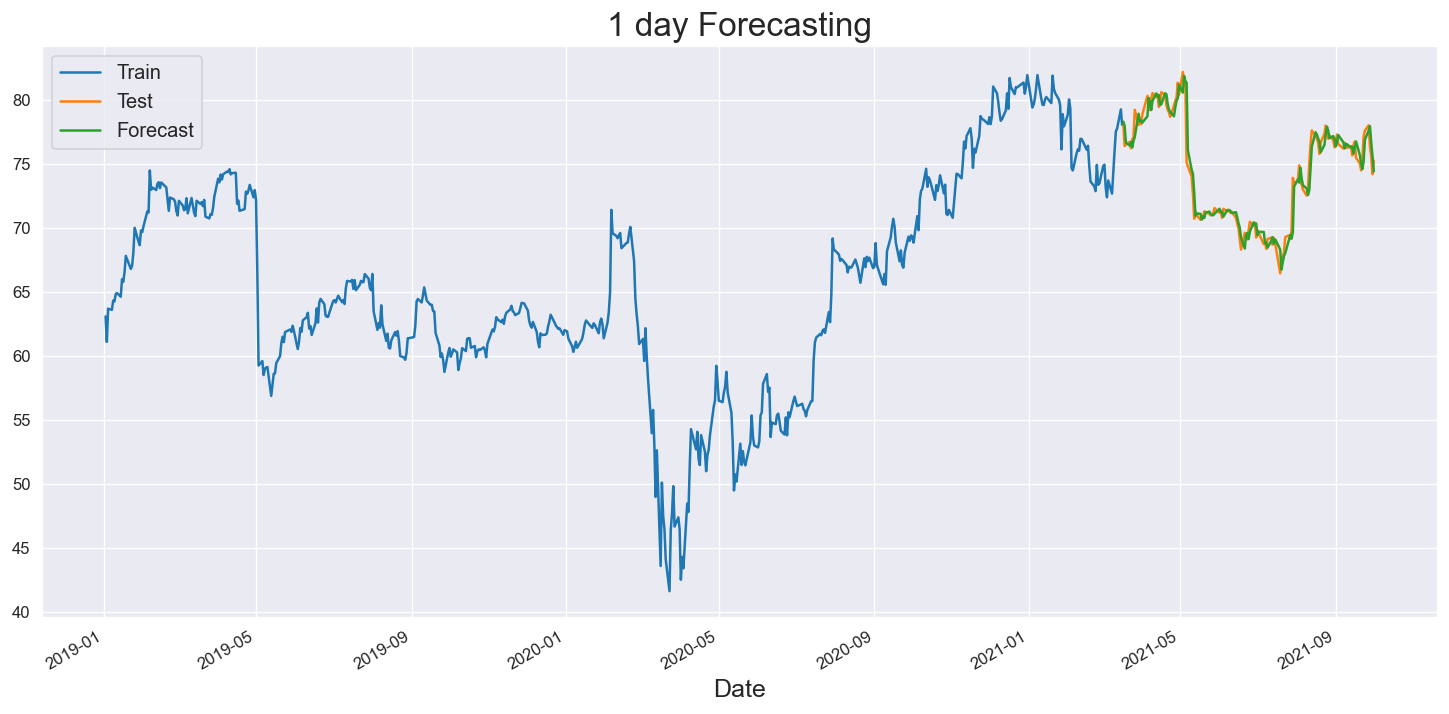

In [266]:
plt.figure(figsize=(15,7))

train.plot()
test.plot()
forecasts.plot()

plt.title('1 day Forecasting',size=20)
plt.xlabel('Date',size=15)
plt.legend(['Train','Test','Forecast'],fontsize='large')
plt.show()

In [86]:
#Metrics
print(f'Mean Absolute Error: {mean_absolute_error(predictions,test)}')
print(f'Mean Squared Error: {mean_squared_error(predictions,test)}')
print(f'R2 score: {r2_score(predictions,test)}')

Mean Absolute Error: 0.6809643513077142
Mean Squared Error: 1.0058951127912743
R2 score: 0.9380363414138985


### Building an LSTM model

In [20]:
scaler = MinMaxScaler()

In [268]:
timesteps = 30

train = df1[:train_size].Close.values.reshape(-1,1)
train_scaled = scaler.fit_transform(train)

X_train = []
y_train = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [269]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [270]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=50))
model.add(Dropout(0.25))

model.add(Dense(units=1))

model.compile(optimizer='Adam',loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
17/17 [==============================] - 1s 11ms/step - loss: 0.1303
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0231
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0175
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 7/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0098
Epoch 8/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 9/20
17/17 [==============================] - 0s 10ms/step - loss: 0.0093
Epoch 10/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0088
Epoch 11/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 12/20
17/17 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 13/20
17/17 [============================

In [271]:
mean_squared_error(train[timesteps:],scaler.inverse_transform(model.predict(X_train)))

17/17 [==============================] - 0s 3ms/step


6.095283950645798

In [272]:
test = df1[train_size:].Close.values.reshape(-1,1)

In [273]:
test_inputs = np.concatenate((train[-timesteps:],test),axis=0)
test_inputs = test_inputs.reshape(-1,1)
test_inputs_scaled = scaler.fit_transform(test_inputs)


In [274]:
X_test = []

for i in range(timesteps,len(test_inputs)):
    X_test.append(test_inputs_scaled[i-timesteps:i])
X_test = np.array(X_test)

In [275]:
predictions =  scaler.inverse_transform(model.predict(X_test))

5/5 [==============================] - 0s 2ms/step


In [276]:
predictions.shape

(139, 1)

In [277]:
forecasts = pd.Series(predictions.reshape(-1), index = df1[train_size:].index)

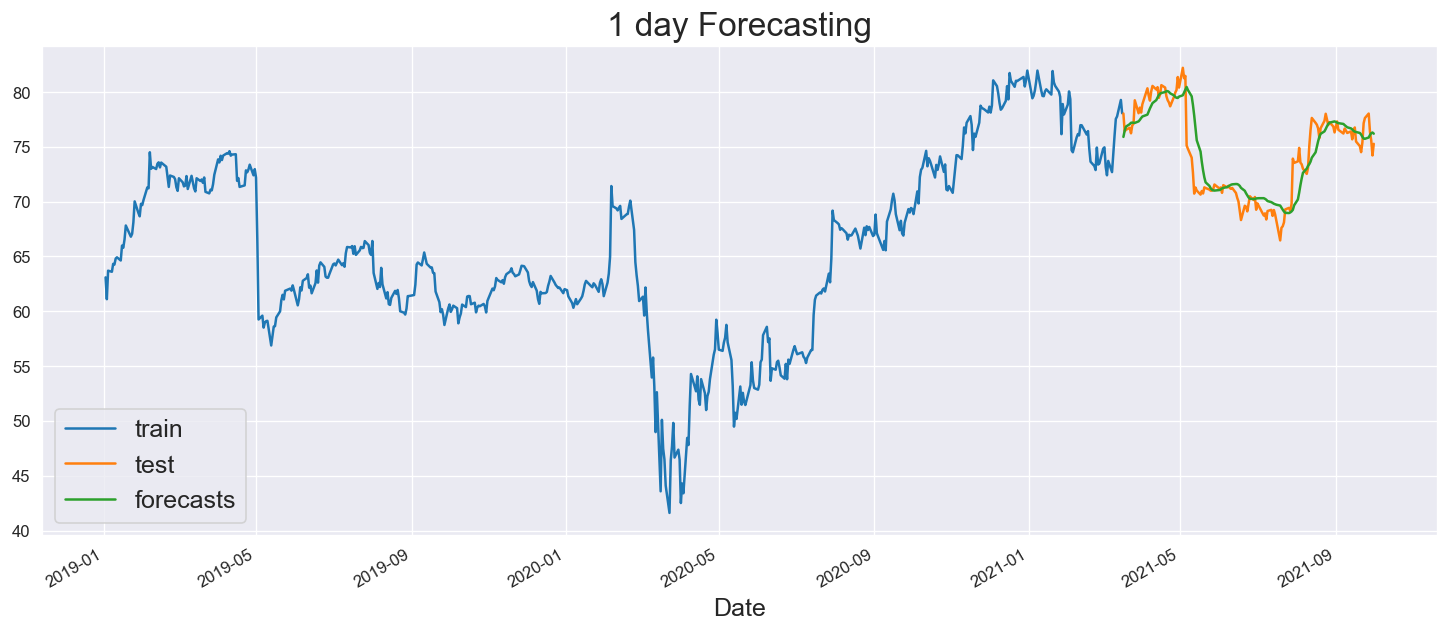

In [289]:
plt.figure(figsize=(15,6))

df1[:train_size].Close.plot()
df1[train_size:].Close.plot()
forecasts.plot()
plt.title('1 day Forecasting',size=20)
plt.xlabel('Date',size=15)

plt.legend(['train','test','forecasts'],fontsize=15)
plt.show()

In [283]:
#Metrics
print(f'Mean Absolute Error: {mean_absolute_error(predictions,test)}')
print(f'Mean Squared Error: {mean_squared_error(predictions,test)}')
print(f'R2 score: {r2_score(predictions,test)}')

Mean Absolute Error: 1.2927636677966226
Mean Squared Error: 3.5764816453031116
R2 score: 0.7272286305206187


### Correlations between the closing prices of different companies

In [184]:
closing_prices = {'cognizant':df1.Close, 'hcl': df2.Close, 'hdfc': df3.Close, 'icici': df4.Close, 'infosys': df5.Close, 'sbi': df6.Close}


In [185]:
closing_prices_df = pd.DataFrame(closing_prices)
closing_prices_df

,cognizant,hcl,hdfc,icici,infosys,sbi
Date,,,,,,
2019-01-01,NaN,NaN,1074.050049,363.750000,NaN,299.600006
2019-01-02,63.090000,NaN,1064.250000,364.600006,NaN,293.899994
2019-01-03,61.099998,NaN,1055.900024,363.250000,NaN,291.100006
2019-01-04,63.700001,NaN,1058.724976,365.200012,NaN,297.649994
2019-01-07,63.599998,NaN,1060.324951,367.700012,NaN,296.299988
...,...,...,...,...,...,...
2021-09-28,76.360001,1269.000000,1615.050049,717.150024,1687.099976,444.899994
2021-09-29,75.580002,1281.199951,1593.849976,709.500000,1692.250000,460.000000
2021-09-30,74.209999,1279.550049,1594.949951,700.849976,1675.199951,453.000000


In [186]:
color_map = {
    'cognizant':'blue',
    'hcl':'orange',
    'hdfc':'green',
    'icici':'red',
    'infosys':'purple',
    'sbi':'brown',
}

<Figure size 1800x720 with 0 Axes>

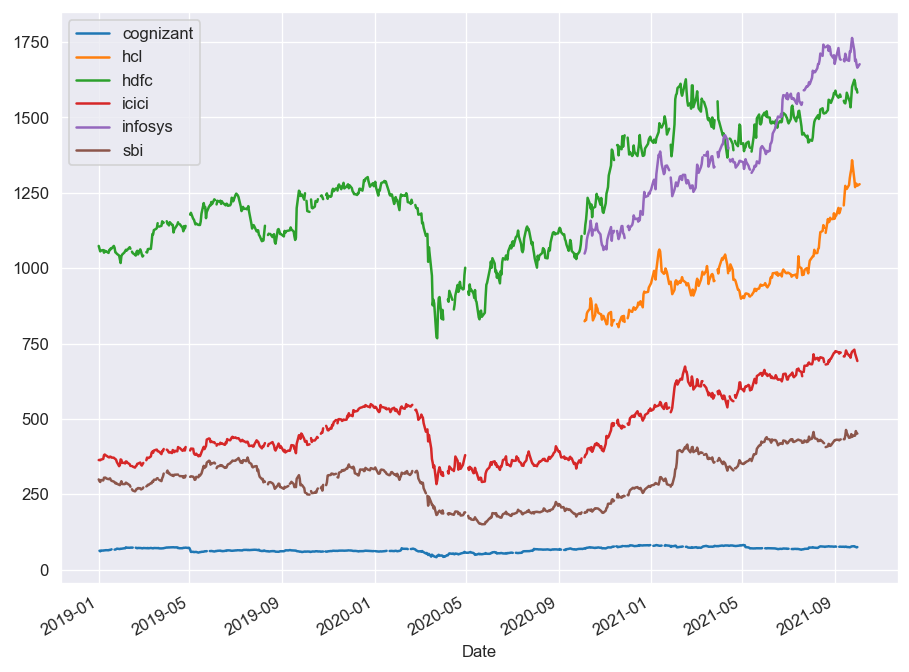

In [187]:
plt.figure(figsize=(15,6))
closing_prices_df.plot()
plt.show()

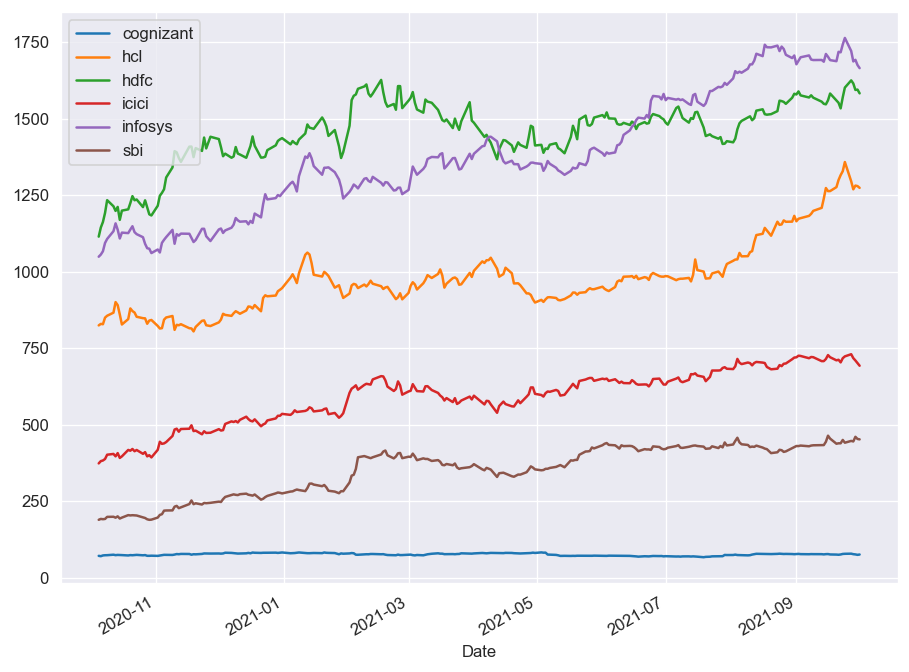

In [192]:
df_copy = closing_prices_df.dropna()
df_copy.plot()
plt.show()

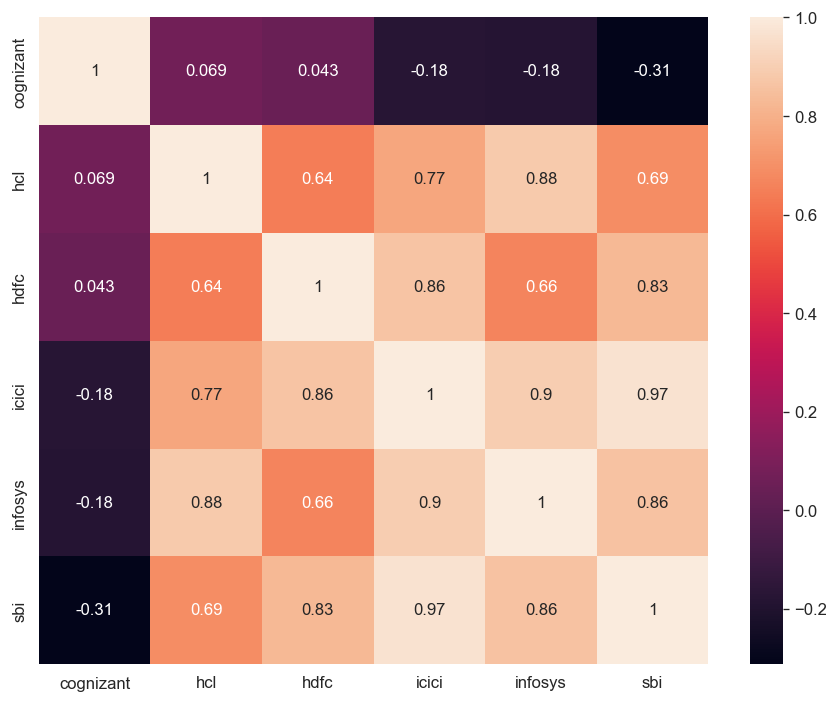

In [193]:
sns.heatmap(df_copy.corr(),annot=True)
plt.show()

In [37]:
df_copy.shape

(240, 6)

In [38]:
X = np.array(df_copy)

In [39]:
#Performing PCA to determine any linear relationships between the closing prices

X_shifted = X - np.mean(X,axis=0)

_,S,VT = np.linalg.svd(X_shifted/math.sqrt(len(X_shifted)))

In [40]:
V = VT.T
eigen = S**2

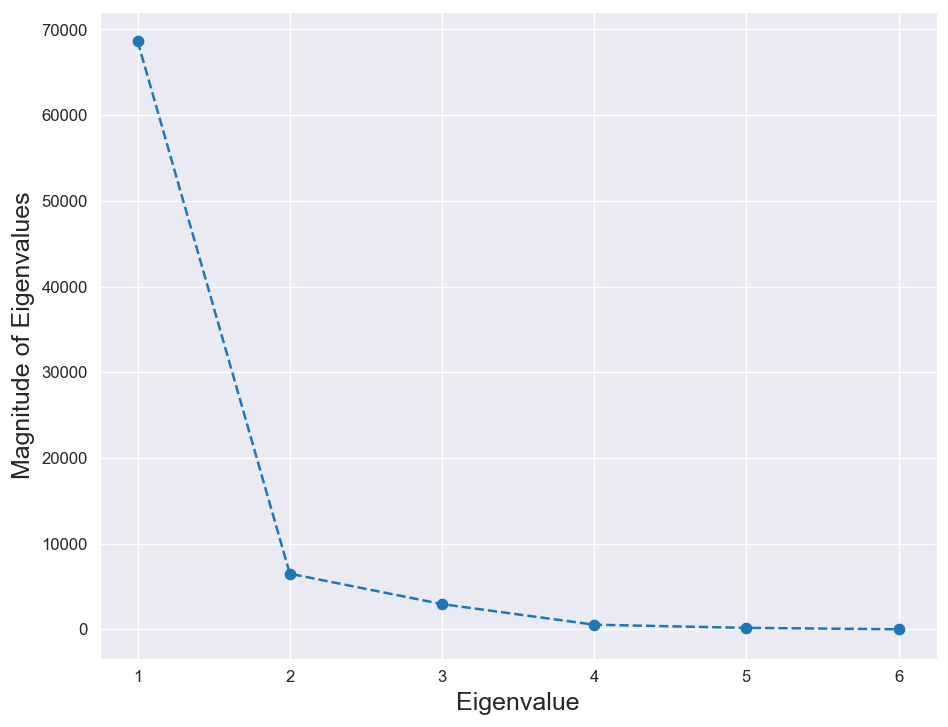

In [290]:
plt.plot(range(1,7),eigen,'o--')
plt.ylabel('Magnitude of Eigenvalues',size=15)
plt.xlabel('Eigenvalue',size=15)
plt.show()

In [42]:
eigenvalues = pd.DataFrame(eigen,index = range(1,7))
eigenvalues.columns = ['EigenValues']
eigenvalues

,EigenValues
1,68624.207267
2,6492.349221
3,2944.789643
4,540.404163
5,170.370751
6,7.123407


There must be at most 1 linear relation between the closing prices of the different companies: it is the eigenvector corresponding to the smallest eigenvalue

In [43]:
print(f'Relationship : {V[:,-1]}')

Relationship : [ 0.99401884 -0.01366898 -0.02233338 -0.04944747  0.00568779  0.09361369]


### Using Linear Regression to determine the linear relationships



In [44]:
#Model 1: The dependent variable is the closing price of the hdfc stock

X = df_copy.drop(['hdfc'],axis=1)
y = df_copy['hdfc']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [46]:
linModel = LinearRegression()
linModel.fit(X_train,y_train)

y_pred = linModel.predict(X_test)

In [80]:
#Metrics
print(f'Mean Absolute Error: {mean_absolute_error(y_pred,y_test)}')
print(f'Mean Squared Error: {mean_squared_error(y_test,y_pred)}')
print(f'R2 score: {r2_score(y_test,y_pred)}')

Mean Absolute Error: 26.35338962159086
Mean Squared Error: 1016.7004946318239
R2 score: 0.935600987699402


In [291]:
feature_names = ['Cognizant','HCL','ICICI', 'Infosys','SBI']
coeff = linModel.coef_

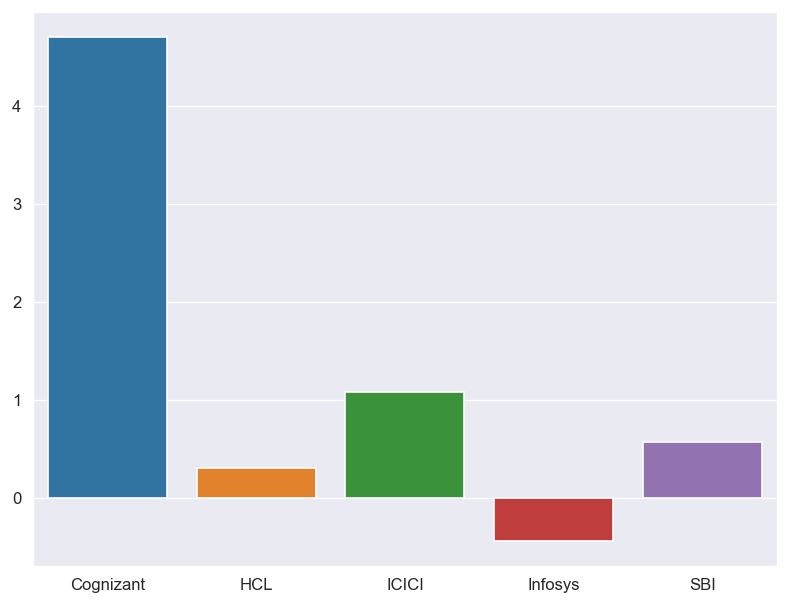

In [294]:
plt.figure(figsize=(8,6))
sns.barplot(x=feature_names,y=coeff)
plt.show()

### Correlations between the trading volumes of the various companies

In [169]:
volumes = {'cognizant':df1.Volume, 'hcl': df2.Volume, 'hdfc': df3.Volume, 'icici': df4.Volume, 'infosys': df5.Volume, 'sbi': df6.Volume}
volumes = pd.DataFrame(volumes)
volumes.head()

,cognizant,hcl,hdfc,icici,infosys,sbi
Date,,,,,,
2019-01-01,NaN,NaN,3186720.0,7759872.0,NaN,11837127.0
2019-01-02,3045600.0,NaN,4067116.0,18243156.0,NaN,25559853.0
2019-01-03,3895700.0,NaN,6385832.0,12884409.0,NaN,17548347.0
2019-01-04,4885600.0,NaN,3643560.0,22896026.0,NaN,19514041.0
2019-01-07,3940400.0,NaN,2693506.0,12719847.0,NaN,14579399.0


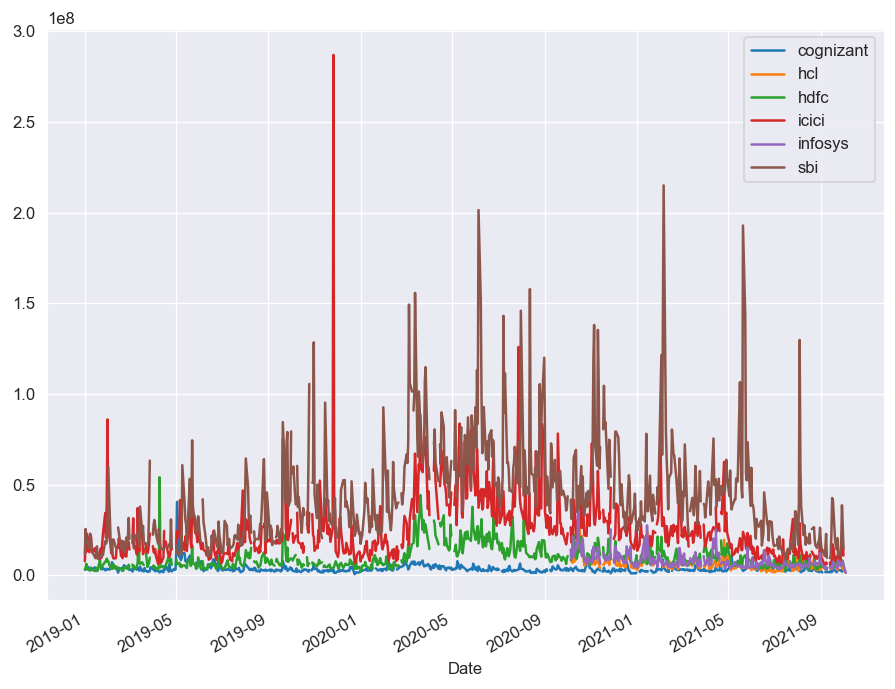

In [174]:
volumes.plot()
plt.show()

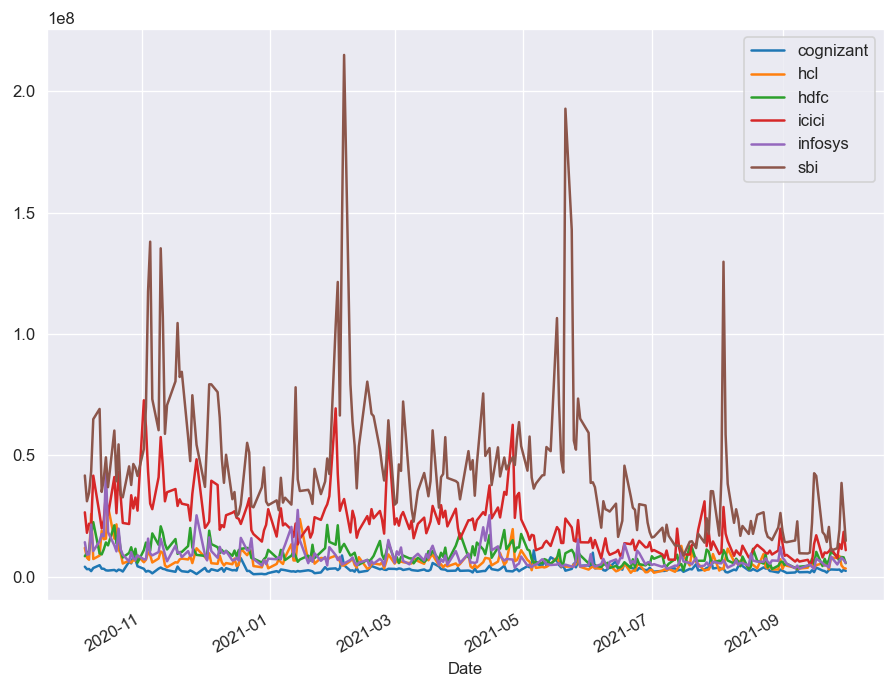

In [180]:
volumes = volumes.dropna()
volumes.plot()
plt.show()

## Analysing SBI's trade volumes

In [199]:
df6.dropna(inplace=True)

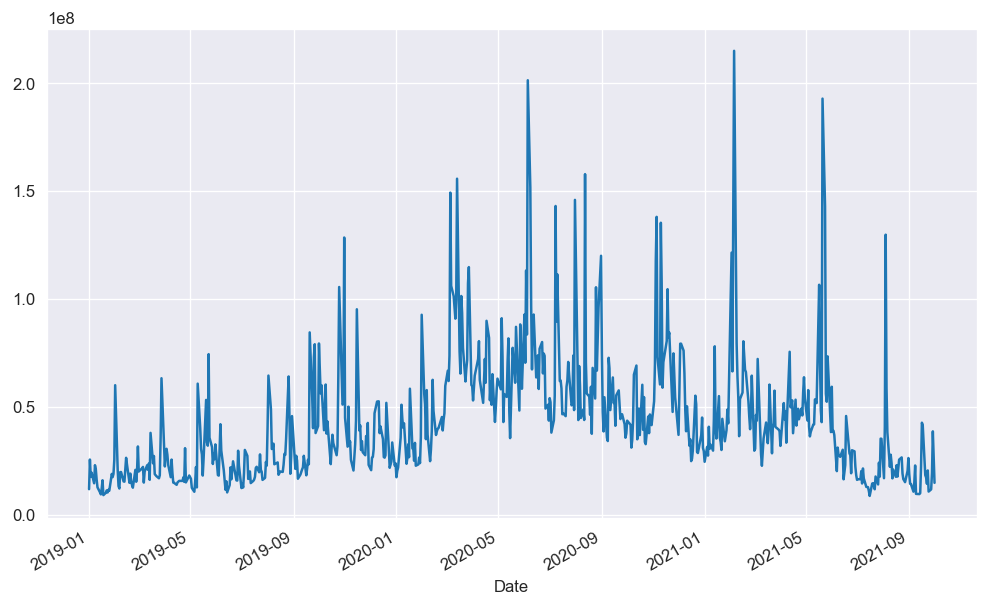

In [200]:
plt.figure(figsize=(10,6))
df6.Volume.plot()
plt.show()

In [218]:
#Performing a seasonal decompose

result = seasonal_decompose(df6.Volume, model='multiplicative', period = 90)

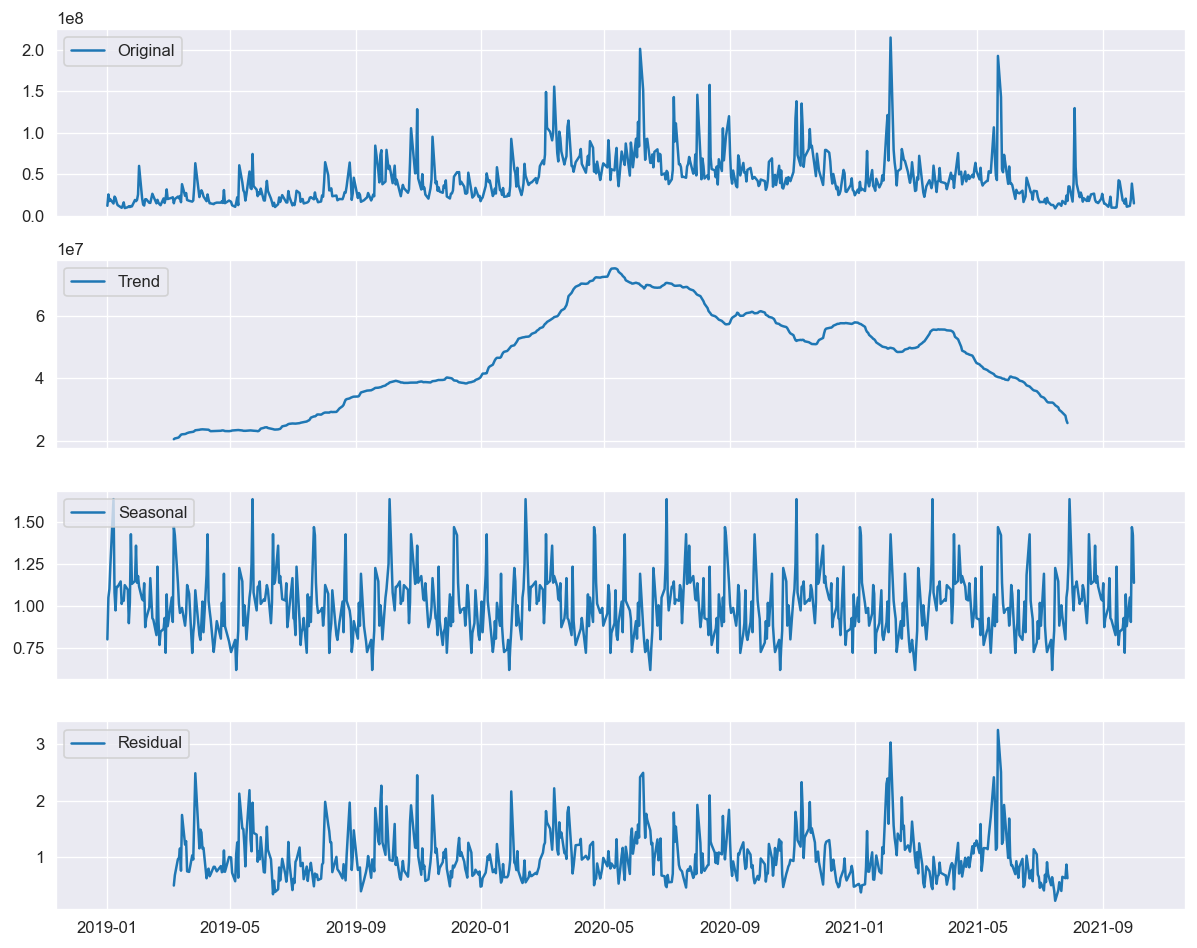

In [219]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(df6.index, df6['Volume'], label='Original')
ax1.legend(loc='upper left')

ax2.plot(df6.index, result.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(df6.index, result.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(df6.index, result.resid, label='Residual')
ax4.legend(loc='upper left')

plt.tight_layout()
plt.show()

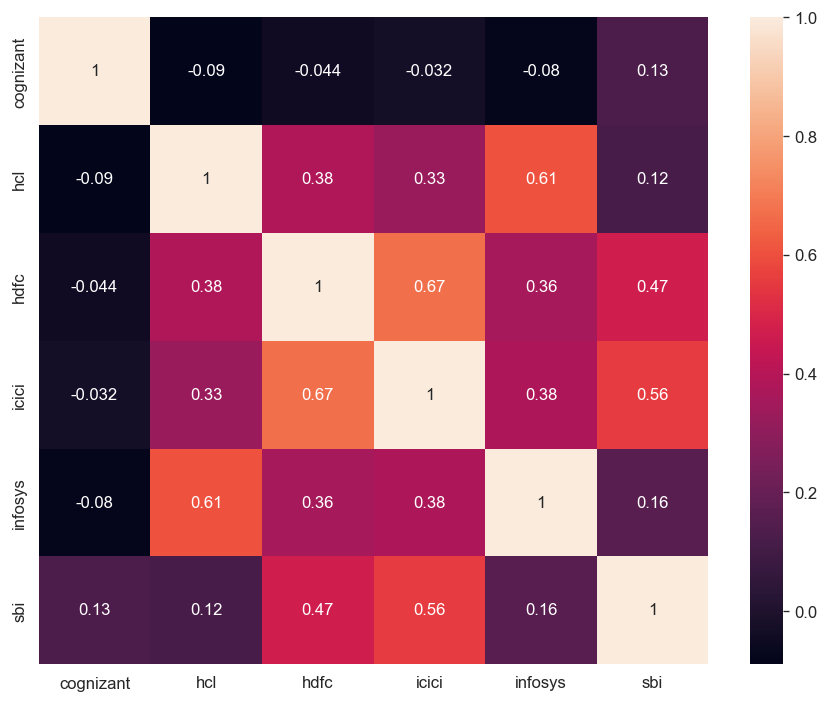

In [194]:
sns.heatmap(volumes.corr(),annot=True)
plt.show()

### Analyzing any correlation that may exist between the closing price of the exchange rate and the closing price of the various companies' stocks

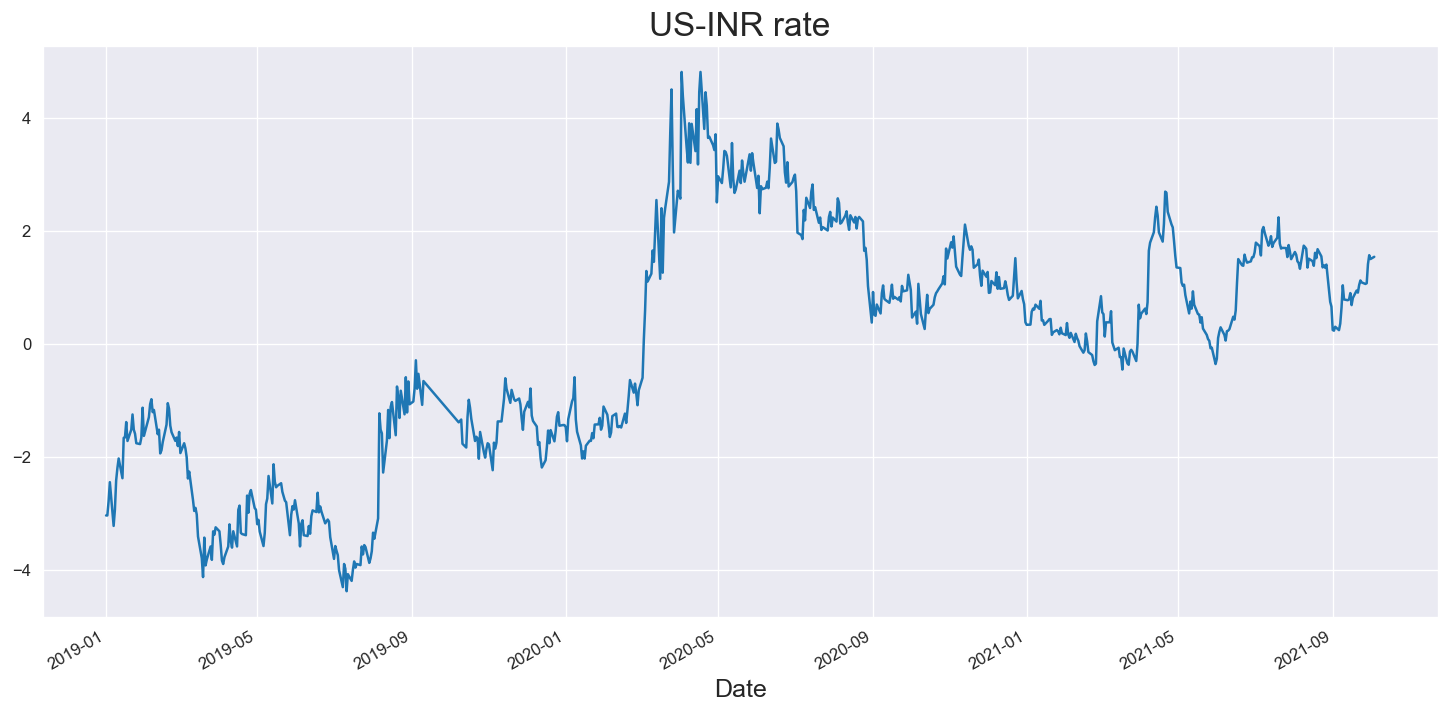

In [298]:
plt.figure(figsize=(15,7))
(df7.Close-df7.Close.mean()).dropna().plot()
plt.title('US-INR rate',size=20)
plt.xlabel('Date',size=15)
plt.show()


In [106]:
new_df = {'cognizant':df1.Close, 'hcl': df2.Close, 'hdfc': df3.Close, 'icici': df4.Close, 'infosys': df5.Close, 'sbi': df6.Close, 'exc':df7.Close}
new_df = pd.DataFrame(new_df)

In [107]:
new_df

,cognizant,hcl,hdfc,icici,infosys,sbi,exc
Date,,,,,,,
2019-01-01,NaN,NaN,1074.050049,363.750000,NaN,299.600006,69.709999
2019-01-02,63.090000,NaN,1064.250000,364.600006,NaN,293.899994,69.709999
2019-01-03,61.099998,NaN,1055.900024,363.250000,NaN,291.100006,69.959999
2019-01-04,63.700001,NaN,1058.724976,365.200012,NaN,297.649994,70.300003
2019-01-07,63.599998,NaN,1060.324951,367.700012,NaN,296.299988,69.525002
...,...,...,...,...,...,...,...
2021-09-28,76.360001,1269.000000,1615.050049,717.150024,1687.099976,444.899994,73.825302
2021-09-29,75.580002,1281.199951,1593.849976,709.500000,1692.250000,460.000000,74.163300
2021-09-30,74.209999,1279.550049,1594.949951,700.849976,1675.199951,453.000000,74.321999


In [109]:
new_df = new_df.dropna()

In [110]:
new_df

,cognizant,hcl,hdfc,icici,infosys,sbi,exc
Date,,,,,,,
2020-10-05,70.930000,824.200012,1114.349976,373.100006,1048.699951,188.750000,73.322403
2020-10-06,69.830002,829.150024,1144.099976,380.600006,1055.750000,191.600006,73.108299
2020-10-07,72.239998,828.049988,1162.250000,382.649994,1066.550049,190.699997,73.815002
2020-10-08,72.910004,849.549988,1191.800049,387.500000,1093.699951,191.500000,73.542503
2020-10-09,73.080002,855.750000,1233.550049,401.500000,1106.800049,198.300003,73.280502
...,...,...,...,...,...,...,...
2021-09-27,78.029999,1295.199951,1625.099976,730.000000,1721.150024,446.600006,73.812897
2021-09-28,76.360001,1269.000000,1615.050049,717.150024,1687.099976,444.899994,73.825302
2021-09-29,75.580002,1281.199951,1593.849976,709.500000,1692.250000,460.000000,74.163300


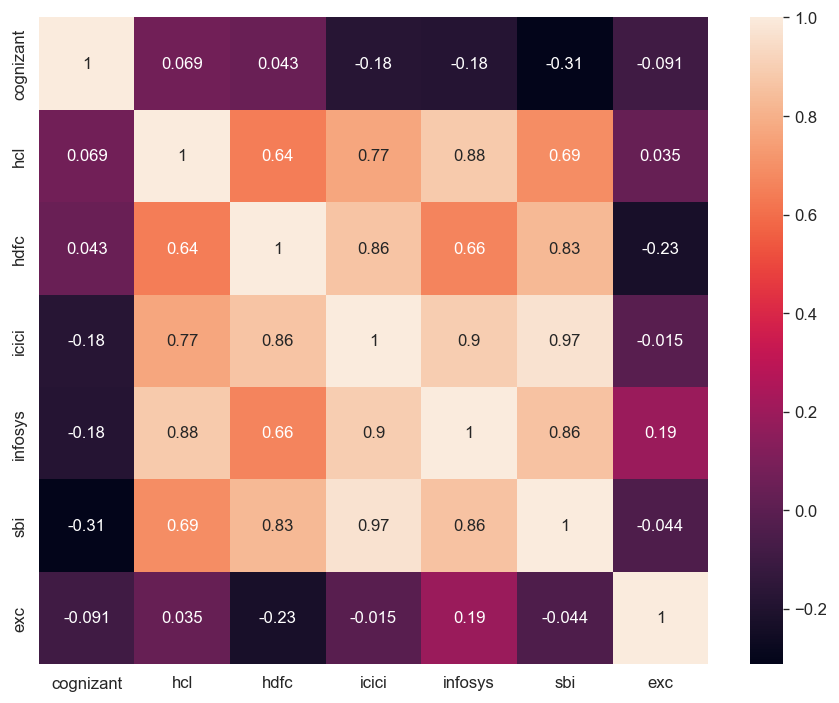

In [111]:
sns.heatmap(new_df.corr(),annot=True)
plt.show()

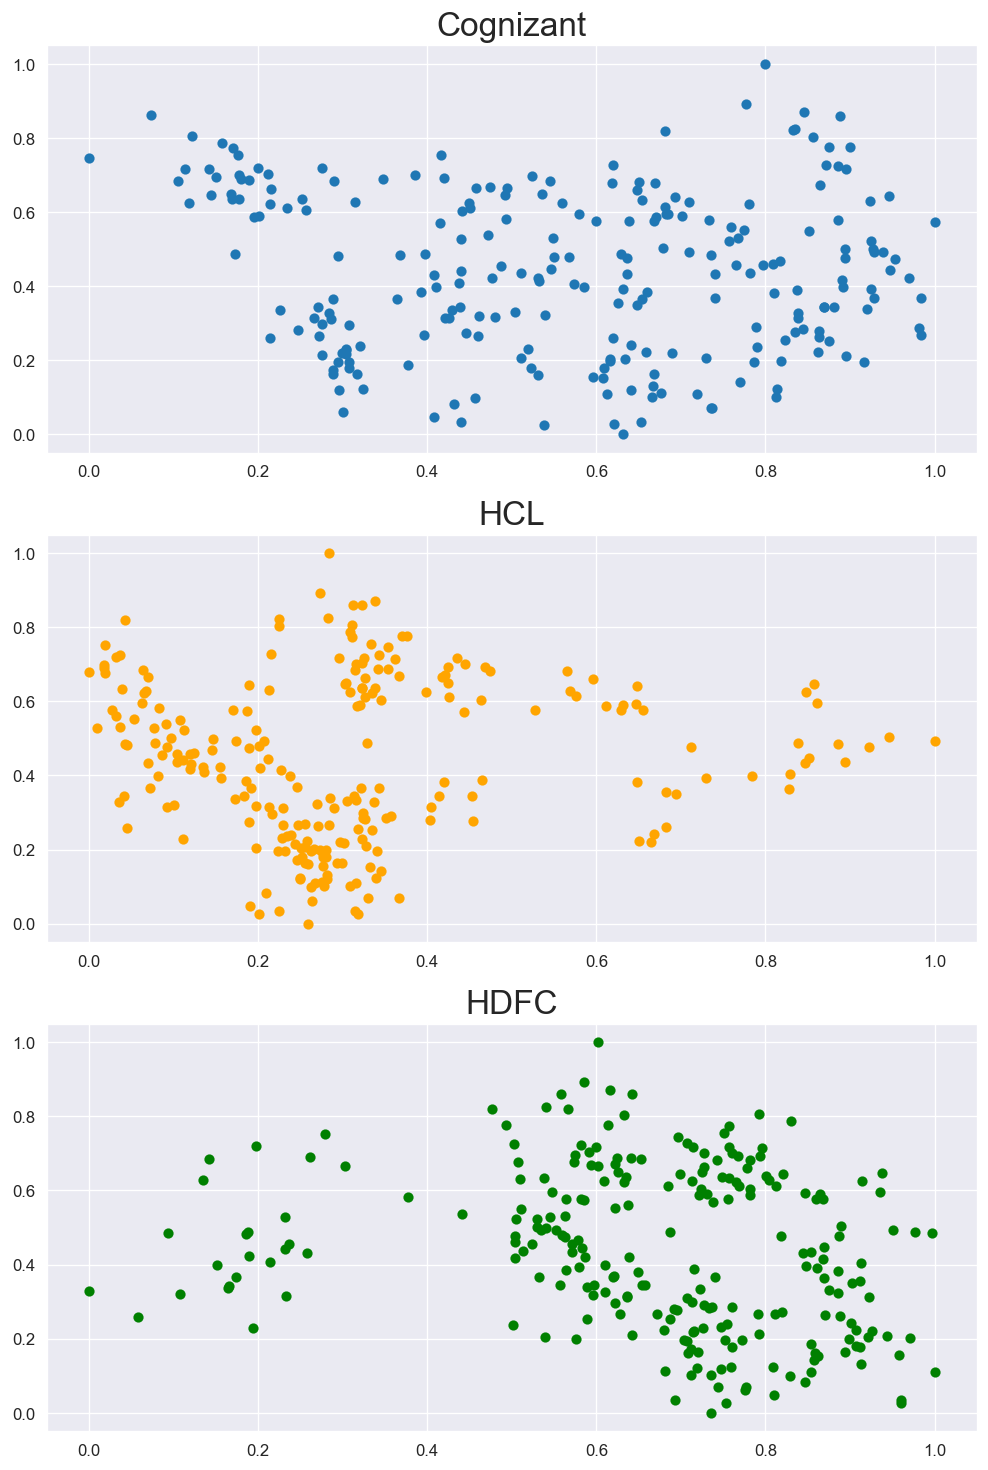

In [302]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

scaler = MinMaxScaler()

y = scaler.fit_transform(new_df.exc.to_numpy().reshape(-1,1))

#Cognizant
x = scaler.fit_transform(new_df.cognizant.to_numpy().reshape(-1,1))
ax[0].set_title('Cognizant',size=20)
ax[0].scatter(x,y,linewidth=0.1)

#HCL
x = scaler.fit_transform(new_df.hcl.to_numpy().reshape(-1,1))
ax[1].set_title('HCL',size=20)
ax[1].scatter(x,y,linewidth=0.1,color=color_map['hcl'])

#HDFC
x = scaler.fit_transform(new_df.hdfc.to_numpy().reshape(-1,1))
ax[2].set_title('HDFC',size=20)
ax[2].scatter(x,y,linewidth=0.1,color=color_map['hdfc'])




plt.show()

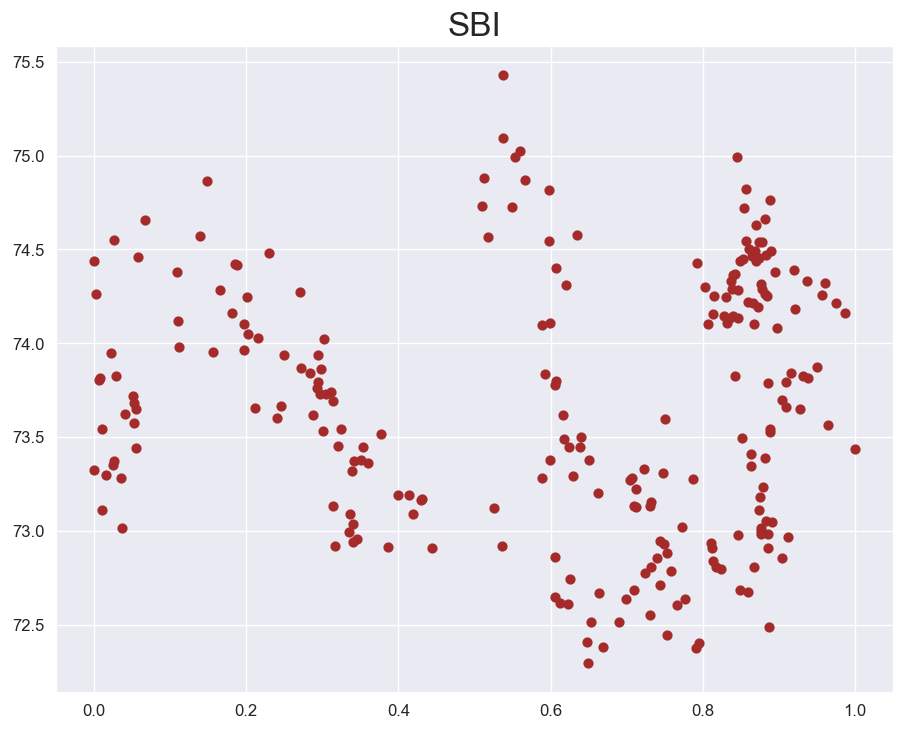

In [316]:
x = scaler.fit_transform(new_df.sbi.to_numpy().reshape(-1,1))
plt.scatter(x,y,linewidth=0.1,color=color_map['sbi'])
plt.title('SBI',size=20)
plt.show()




In [312]:
#Model 1: Random Forest Regressor

rf = RandomForestRegressor(n_estimators=200)

X = new_df.drop(['exc'],axis=1)
y = new_df['exc']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42,shuffle=True)

In [313]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [314]:
#Metrics
print(f'Mean Absolute Error: {mean_absolute_error(y_pred,y_test)}')
print(f'Mean Squared Error: {mean_squared_error(y_test,y_pred)}')
print(f'R2 score: {r2_score(y_test,y_pred)}')

Mean Absolute Error: 0.24997747375001111
Mean Squared Error: 0.10336827284259563
R2 score: 0.81655193784527


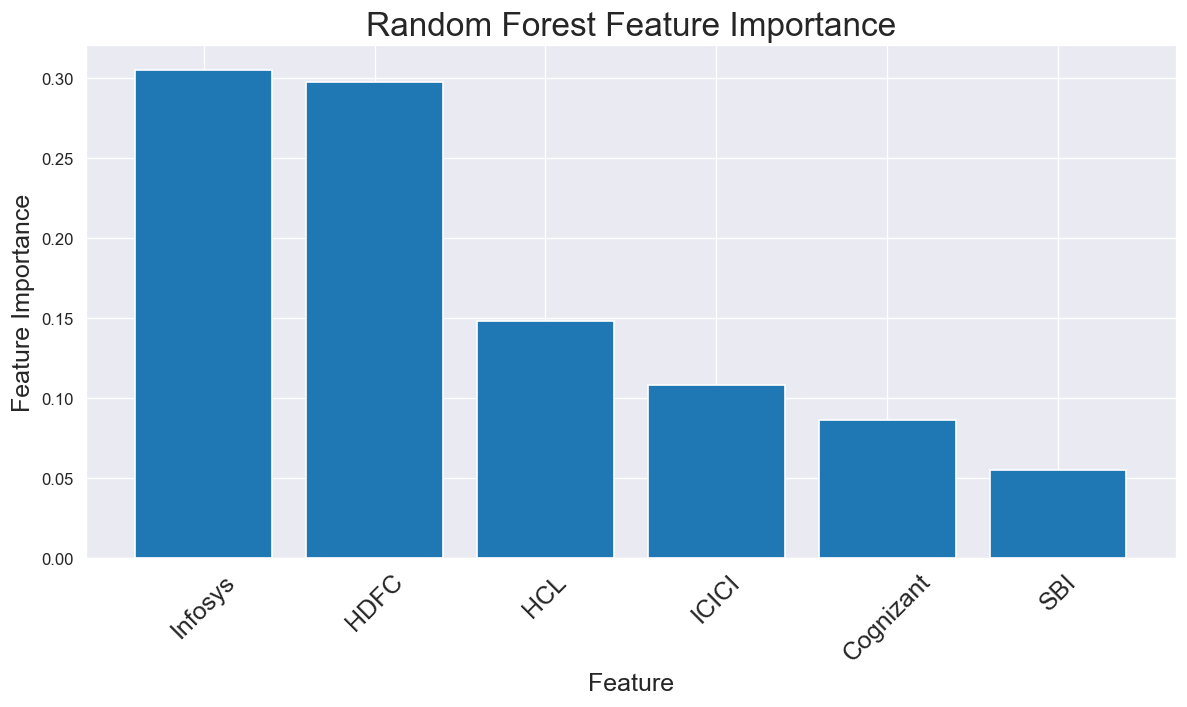

In [160]:
feature_names = ['Cognizant','HCL','HDFC','ICICI','Infosys','SBI']
feature_importances = rf.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45,size=15)
plt.xlabel('Feature',size=15)
plt.ylabel('Feature Importance',size=15)
plt.title('Random Forest Feature Importance',size=20)
plt.tight_layout()
plt.show()

In [161]:
#Model 2: Xtreme Gradient Boosting

xgboost = xgb.XGBRegressor(n_estimators=200)
xgboost.fit(X_train,y_train)
y_pred = xgboost.predict(X_test)


In [162]:
#Metrics
print(f'Mean Absolute Error: {mean_absolute_error(y_pred,y_test)}')
print(f'Mean Squared Error: {mean_squared_error(y_test,y_pred)}')
print(f'R2 score: {r2_score(y_test,y_pred)}')

Mean Absolute Error: 0.30117832132975114
Mean Squared Error: 0.1351563656757908
R2 score: 0.7601374900705239


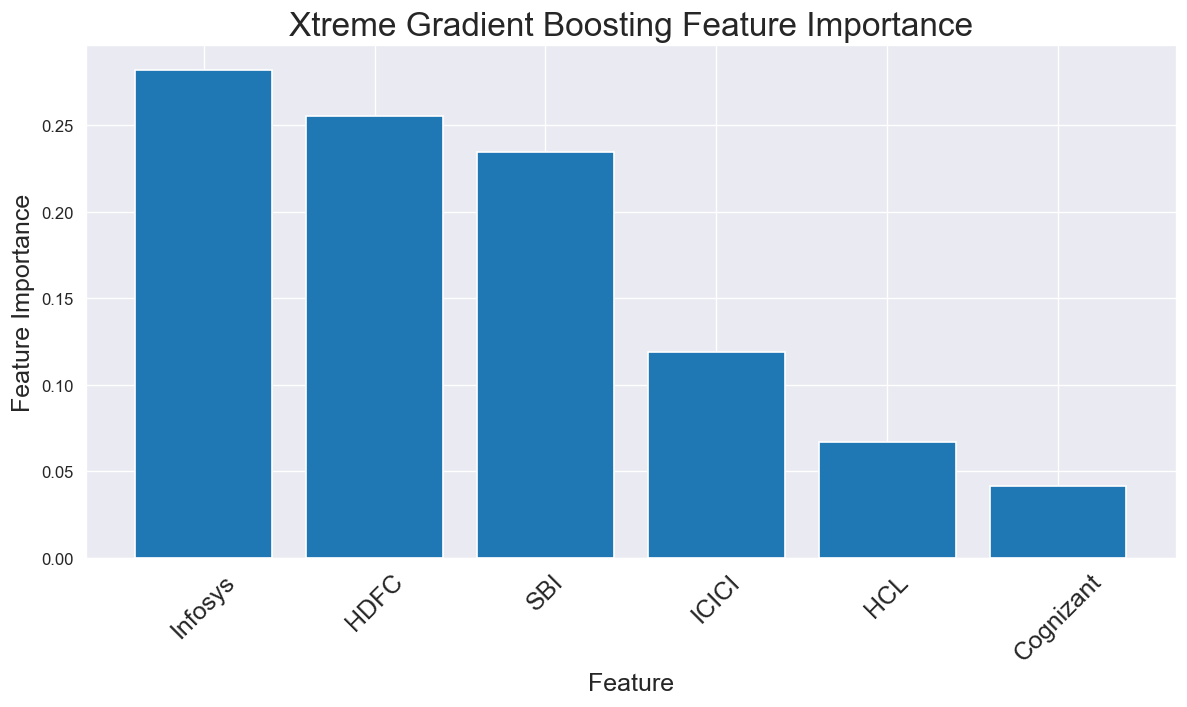

In [164]:
feature_names = ['Cognizant','HCL','HDFC','ICICI','Infosys','SBI']
feature_importances = xgboost.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45,size=15)
plt.xlabel('Feature',size=15)
plt.ylabel('Feature Importance',size=15)
plt.title('Xtreme Gradient Boosting Feature Importance',size=20)
plt.tight_layout()
plt.show()